# CCS Bistable Mechanical Beam

Centrally-Clamped Stepped (CCS) bistable mechanical beam for nonvolatile
silicon photonic MEMS switching.

Implements the exact geometry from:
> Ma et al., *"Nonvolatile Silicon Photonic MEMS Switch Based on Centrally-Clamped
> Stepped Bistable Mechanical Beams"* (Zhejiang University, 2024)

## Design overview

The CCS beam replaces the uniform cosine-shaped bistable beam with a
**hybrid structure**: thin flexible cosine-shaped sections near the anchors
and wide rigid straight sections in the center.  This produces:

- **Stronger bistability**: switching-ON/OFF force ratio = 0.87 (vs 0.76 for pure cosine)
- **Higher switching forces**: more robust against parasitic spring loads from suspended waveguides
- **Nonvolatile switching**: no drive voltage needed to hold either stable state

## Key dimensions

| Parameter | Value |
|-----------|-------|
| Total span (anchor-to-anchor) | 40 um |
| Flexible beam width | 0.1 um |
| Rigid beam width | 0.4 um |
| Flex : rigid length ratio | 3 : 7 (12 um : 28 um) |
| Initial max y-offset | 0.2 um |
| Post-release travel between states | ~1.2 um |
| Switching energy per set | 64 fJ / 58 fJ |
| Fabrication | 220 nm SOI, 2 um BOX |

In [1]:
import sys
sys.path.insert(0, "../../libraries")

from mcw_custom_optical_mems_pdk import PDK
PDK.activate()

from ccs_bistable_beam import make_ccs_beam, make_ccs_beam_set

## Single CCS beam

One beam from left anchor to right anchor. The centerline follows:
- **Cosine curve** in the flexible sections (near anchors, 6 um per side)
- **Straight line** in the rigid sections (center, 14 um per side)
- **C1-continuous** taper transitions at every boundary

The as-fabricated shape has a 0.2 um offset at center. After BOX release
and residual stress relief, the beam buckles to its first stable state
with ~0.6 um additional offset.

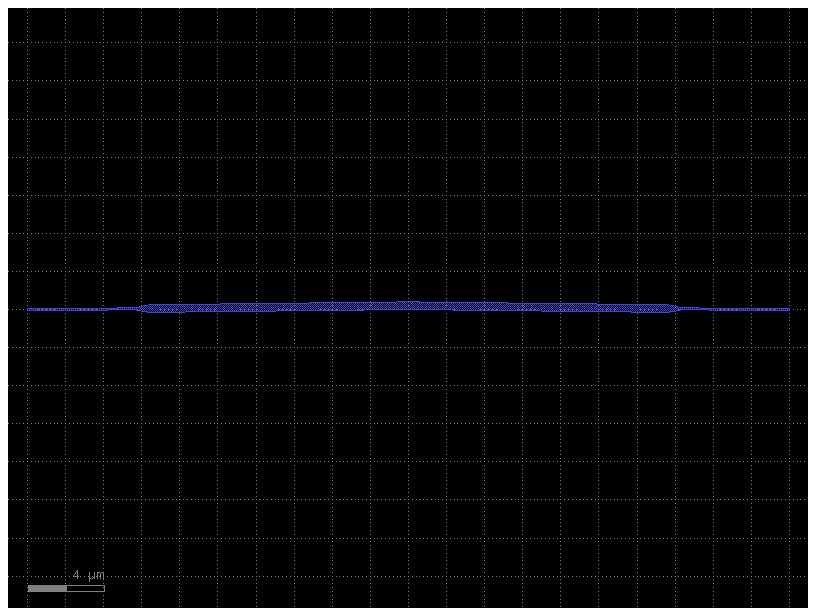

In [2]:
beam = make_ccs_beam(
    span=40.0,            # anchor-to-anchor (um)
    flex_ratio=0.3,       # 3/10 of span = 12 um total flexible
    flex_width=0.1,       # thin cosine sections (um)
    rigid_width=0.4,      # wide straight sections (um)
    initial_offset=0.2,   # max y-offset at center (um)
    taper_length=1.0,     # smooth width transition (um)
)
beam.plot()

## Beam centerline profile

Visualize the cosine + straight hybrid centerline shape and the width
variation along the beam. The flexible sections carry all the curvature
while the rigid sections remain straight.

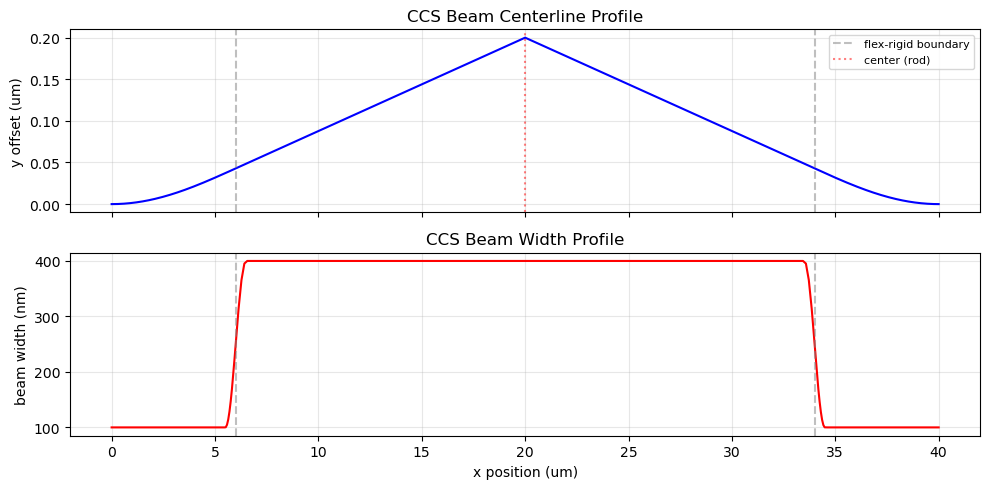

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ccs_bistable_beam import _compute_ccs_centerline, _compute_width_profile

span, flex_ratio, h = 40.0, 0.3, 0.2
x, y = _compute_ccs_centerline(span, flex_ratio, h)
w = _compute_width_profile(x, span, flex_ratio, 0.1, 0.4, 1.0)

L_flex = flex_ratio * span / 2  # = 6 um per side

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# Centerline
ax1.plot(x, y, 'b-', linewidth=1.5)
ax1.axvline(L_flex, color='gray', linestyle='--', alpha=0.5, label='flex-rigid boundary')
ax1.axvline(span - L_flex, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(span / 2, color='r', linestyle=':', alpha=0.5, label='center (rod)')
ax1.set_ylabel('y offset (um)')
ax1.set_title('CCS Beam Centerline Profile')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# Width profile
ax2.plot(x, w * 1000, 'r-', linewidth=1.5)  # convert to nm
ax2.axvline(L_flex, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(span - L_flex, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('x position (um)')
ax2.set_ylabel('beam width (nm)')
ax2.set_title('CCS Beam Width Profile')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## CCS beam set (parallel pair with anchors and rod)

A complete set as used in the switch: two parallel CCS beams connected
at their centers by a rigid rod to the shuttle.  Anchor pads (2 um wide)
remain bonded to the BOX after release.

The full switch uses **two sets** (one on each side of the shuttle) plus
a bidirectional electrostatic comb actuator.  Switching voltages:
- 12 V to switch OFF (beams snap to 2nd stable state)
- 9 V to switch ON (beams snap back to 1st stable state)

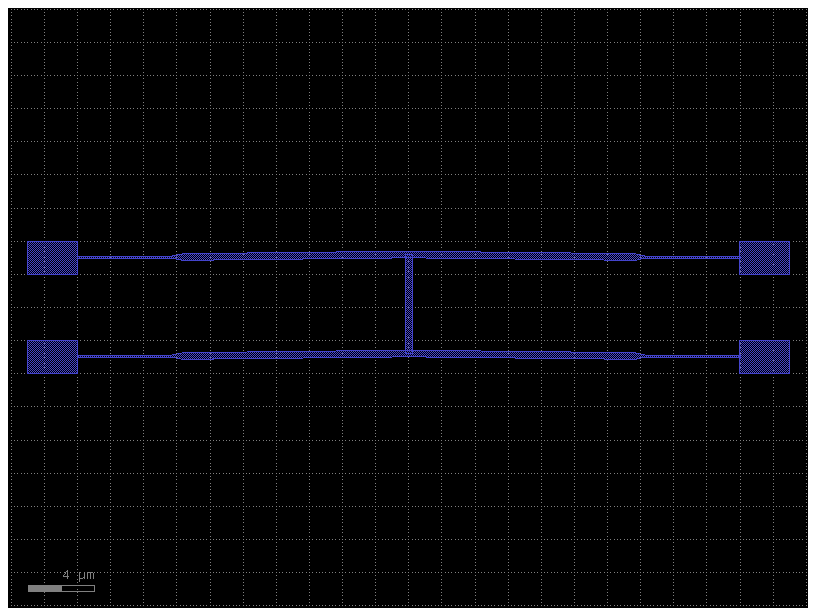

In [4]:
beam_set = make_ccs_beam_set(
    span=40.0,
    flex_ratio=0.3,
    flex_width=0.1,
    rigid_width=0.4,
    initial_offset=0.2,
    taper_length=1.0,
    beam_spacing=6.0,     # center-to-center between beams (um)
    rod_width=0.4,        # rod connecting beams to shuttle (um)
    anchor_width=2.0,     # anchor pads survive HF release (um)
    anchor_length=3.0,    # anchor extent beyond beam span (um)
)
beam_set.plot()

## Export GDS

Write the beam set cell to a GDS file in this component's directory.

In [5]:
gds_path = beam_set.write_gds("ccs_bistable_beam.gds")
print(f"GDS written to: {gds_path}")

GDS written to: ccs_bistable_beam.gds
